# Neural Network for Clustering PI-ICR Spots

Author: Scott Campbell

This notebook trains a neural network for clustering data that is similar to what PI-ICR data may look like.

In [2]:
# import the necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Create a Dataset of Simulated Data

In [3]:
nx = 50
mcp_radius = 50

x_list = np.linspace(-mcp_radius, mcp_radius, nx)
mesh_X, mesh_Y = np.meshgrid(x_list, x_list)
dx = x_list[1] - x_list[0]

def __get_data_for_NN__(shot_x, shot_y, normalize=True):
    """ This method take a list of shots, discretizes to the domain, and normalizes so that the grid sums to one
    Args: 
        shot_x (list): list of x coords of each shot. Shots outside MCP radius are ignored
        shot_y (list): list of y coords of each shot. Shots outside MCP radius are ignored
    Returns:
        a 1D list (row-wise) corresponding to the normalized MCP hits
    """
    Z = np.zeros(mesh_X.shape) # Create a blank array to store shot info
    for kk in range(len(shot_x)):
        if np.sqrt(shot_x[kk]**2 + shot_y[kk]**2) < mcp_radius:
            x_idx, y_idx = int((shot_x[kk] + mcp_radius)/dx), int((shot_y[kk] + mcp_radius)/dx)
            Z[y_idx][x_idx] += 1
    if normalize: 
        Z = Z / np.sum(Z) # Normalize so that Z sums to 1
    return Z.reshape((nx**2))

In [5]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def generate_spot_data(num_sim_samples):
    # TODO: add multiple cluster functionality
    max_ellipse_offset = 0.1*mcp_radius # allow the ellipse to be offset by up to X% mcp radius
    max_ellipse_ab_diff = 0.15 # the ellipse params can't be more than this percent diff
    min_percent_noise = 0.75 # min amount of noise relative to the cluster data
    max_percent_noise = 2 # max amount of noise relative to the cluster data
    min_cluster_radius = 0.05*mcp_radius # min 'radius' of the cluster data
    max_cluster_radius = 0.27*mcp_radius # max 'radius' of the cluster data
    min_num_cluster_data = 50 
    max_num_cluster_data = 200 # up to this many shots in a cluster

    start_time = time.time()
    all_input = []
    all_output = []
    for _ in range(num_sim_samples):
        # define the cluster
        n_cluster = np.random.randint(min_num_cluster_data, high=max_num_cluster_data)
        cluster_theta = np.random.uniform(low=0, high=2*np.pi) # cluster angle on un-rotated ellipse
        cluster_radius = np.random.uniform(low=min_cluster_radius, high=max_cluster_radius)
        # 80% random, 20% normal dist
        cluster_xy = np.random.uniform(low=-cluster_radius, high=cluster_radius, size=(int(.8*n_cluster),2))
        cluster_xy = np.concatenate((cluster_xy, np.random.normal(loc=0, scale=0.65*cluster_radius, size=(int(.8*n_cluster),2))))
        cluster_x, cluster_y = cluster_xy[:,0], cluster_xy[:,1]

        # define an offset
        off_x, off_y = np.random.uniform(low=0, high=max_ellipse_offset), np.random.uniform(low=0, high=max_ellipse_offset)
        # define the elipse major/minor axes
        max_ellipse_ab = mcp_radius - np.sqrt(off_x**2 + off_y**2) - cluster_radius
        ellipse_a = np.random.uniform(low=0, high=max_ellipse_ab)
        ellipse_b = np.random.uniform(low=(1-max_ellipse_ab_diff)*ellipse_a, high=ellipse_a) 
        # define angle of ellipse
        ellipse_theta = np.random.uniform(low=0, high=2*np.pi)

        # Put the cluster on the ellipse 
        r_at_theta = np.sqrt((ellipse_a*np.cos(cluster_theta))**2 + (ellipse_b*np.sin(cluster_theta))**2) # dist from ellipse center to cluster
        cluster_x += r_at_theta*np.cos(cluster_theta)
        cluster_y += r_at_theta*np.sin(cluster_theta)
        
        # translate and rotate the ellipse in space
        cluster_rho, cluster_phi = cart2pol(cluster_x, cluster_y)
        cluster_phi += ellipse_theta
        cluster_x, cluster_y = pol2cart(cluster_rho, cluster_phi)
        cluster_x, cluster_y = cluster_x + off_x, cluster_y + off_y

        # Generate noise along the ellipse, strongest near the cluster
        # 70% on the ellipse, 30% random
        n_noise = n_cluster * np.random.uniform(low=min_percent_noise, high=max_percent_noise)
        noise_sigma = np.random.uniform(low=0.5, high=1) # from ~30deg to ~60%
        noise_phi = np.random.normal(loc=cluster_theta, scale=noise_sigma, size=int(0.7*n_noise))

        noise_x = np.array([off_x+ellipse_a*np.cos(t) for t in noise_phi])
        noise_y = np.array([off_y+ellipse_b*np.sin(t) for t in noise_phi])
        noise_rho, noise_phi = cart2pol(noise_x, noise_y)
        noise_rho = np.add(noise_rho, np.random.normal(loc=0, scale=0.32*cluster_radius, size=len(noise_rho)))
        noise_phi += ellipse_theta
        noise_x, noise_y = pol2cart(noise_rho, noise_phi)
        # add in the random noise as well 
        other_noise_rho = np.random.uniform(low=0, high=mcp_radius, size=int(0.3*n_noise))
        otehr_noise_theta = np.random.uniform(low=0, high=2*np.pi, size=int(0.3*n_noise))
        other_noise_x, other_noise_y = pol2cart(other_noise_rho, otehr_noise_theta)
        # Concatentate all the noise
        noise_x, noise_y = np.concatenate((noise_x,other_noise_x)), np.concatenate((noise_y,other_noise_y))

        # plt.figure()
        # plt.scatter(cluster_x, cluster_y)
        # plt.scatter(noise_x, noise_y)
        # t = np.linspace(0, 2*np.pi, 100)
        # ellipse_x, ellipse_y = off_x+ellipse_a*np.cos(t), off_y+ellipse_b*np.sin(t)
        # ellipse_rho, ellipse_phi = cart2pol(ellipse_x, ellipse_y)
        # ellipse_phi += ellipse_theta 
        # ellipse_x, ellipse_y = pol2cart(ellipse_rho, ellipse_phi)
        # plt.plot(ellipse_x, ellipse_y, '-r')
        # plt.title("rotated and translated cluster on ellipse")
        # plt.show()

        # Finally, get the neural network input
        all_x, all_y = np.concatenate((cluster_x,noise_x)), np.concatenate((cluster_y,noise_y))
        input = __get_data_for_NN__(all_x, all_y)
        output = __get_data_for_NN__(cluster_x, cluster_y)

        # Scale up the input for faster training - each cell should be ~1
        input *= nx**2
        output[output > 0] = 1

        all_input.append(input)
        all_output.append(output)

    print("Finished computing. Avg time per sample (s):", (time.time() - start_time)/num_sim_samples )
    return np.array(all_input), np.array(all_output)

# NOTE: X is rescaled such that the sum of every pixel equals nx^2
# NOTE: y is changed such that a pixel in the cluster has value 1, else 0
X_data, y_data = generate_spot_data(50000)
data_size = len(X_data[0])

# Split the data into training and validation (85:15)
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, train_size=0.85)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

Finished computing. Avg time per sample (s): 0.0009390963935852051
X_train: (42500, 2500)
y_train: (42500, 2500)
X_valid: (7500, 2500)
y_valid: (7500, 2500)


## Create the Neural Network

We are doing multi-label classification, where more then one feature can be 'true': a pixel is in the cluster

In [7]:
# Define some parameters for training the data
num_epochs = 10
batch_size = 64

# Create the neural network model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(data_size, kernel_initializer='he_uniform', activation="relu")) # Input layer

#model.add(tf.keras.layers.Dense(int(1.5*data_size), activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(data_size, activation="sigmoid")) # Output layer

#optimizer = tf.keras.optimizers.SGD() # Adam optimizer far outperforms the SGD optimizer for this problem
optimizer = tf.keras.optimizers.Adam() # 1e-4 works pretty well to optimize the fastest. Maybe add schedule to decrease for later epochs?
model.compile(loss="binary_crossentropy", optimizer=optimizer,  metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

Epoch 1/10
665/665 [==============================] - 39s 57ms/step - loss: 0.0539 - accuracy: 6.3529e-04 - val_loss: 0.0387 - val_accuracy: 1.3333e-04
Epoch 2/10
665/665 [==============================] - 39s 59ms/step - loss: 0.0393 - accuracy: 1.1765e-04 - val_loss: 0.0383 - val_accuracy: 0.0000e+00
Epoch 3/10
665/665 [==============================] - 42s 63ms/step - loss: 0.0384 - accuracy: 3.0588e-04 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 4/10
665/665 [==============================] - 50s 76ms/step - loss: 0.0378 - accuracy: 2.1176e-04 - val_loss: 0.0388 - val_accuracy: 2.6667e-04
Epoch 5/10
665/665 [==============================] - 51s 77ms/step - loss: 0.0374 - accuracy: 2.5882e-04 - val_loss: 0.0392 - val_accuracy: 2.6667e-04
Epoch 6/10
665/665 [==============================] - 51s 77ms/step - loss: 0.0370 - accuracy: 5.1765e-04 - val_loss: 0.0395 - val_accuracy: 0.0000e+00
Epoch 7/10
665/665 [==============================] - 54s 81ms/step - loss: 0.0366 - acc

## Look at the Results for Test Data

Finished computing. Avg time per sample (s): 0.001182723045349121
1/1 [==============================] - 0s 19ms/step


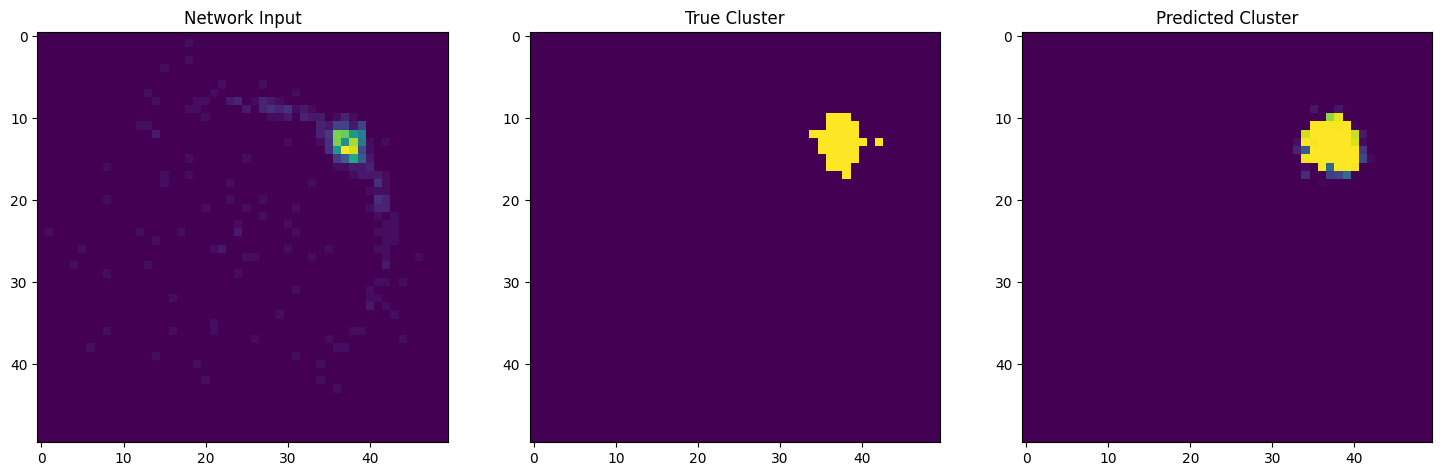

In [14]:
from matplotlib import cm

X_test, y_test = generate_spot_data(10)

# Get the predictions on the unknown testing set
y_pred = model.predict(X_test)

# Plot for random indices
index = np.random.randint(0, high=len(y_test))
curr_X_test, curr_y_test, curr_y_pred = X_test[index], y_test[index], y_pred[index]

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(curr_X_test.reshape((50,50)), cmap=cm.viridis)
plt.title("Network Input")
plt.subplot(1,3,2)
plt.title("True Cluster")
plt.imshow(curr_y_test.reshape((50,50)), cmap=cm.viridis)
plt.subplot(1,3,3)
plt.title("Predicted Cluster")
plt.imshow(curr_y_pred.reshape((50,50)), cmap=cm.viridis)

### Save the classifier for use later

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("PI-ICR_SingleSpot_Cluster_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("PI-ICR_SingleSpot_Cluster_Model.h5")